# Clustering

In [13]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
dateparse = lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S%z")  # pd.datetime.strptime

core_users_clustering = pd.read_csv("../data/core_users_clustering.csv",
                    parse_dates=['created_at'],
                    converters={"user_id": str})

In [3]:
core_users_clustering_copy = core_users_clustering.copy()

## K-Means

### Data preprocessing

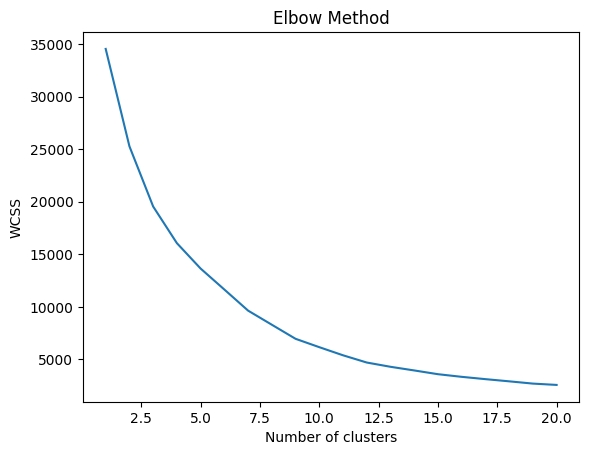

In [9]:
# Seleziona le caratteristiche da utilizzare per il clustering
features = ['nbr_followers', 'nbr_followings', 'nbr_liked_tweets', 'nbr_lists', 'nbr_tweets', 'nbr_usernames', 'following_ratio', 'followers_ratio', 'favorites_ratio', 'tweet_ratio']

# Standardizzazione delle features
core_users_standardized = (core_users_clustering[features] - core_users_clustering[features].mean()) / core_users_clustering[features].std()
# Normalizzazione delle features
# core_users_normalized = (core_users_clustering[features] - core_users_clustering[features].min()) / (core_users_clustering[features].max() - core_users_clustering[features].min())

# Sostituisci i valori mancanti con 0
core_users_standardized = core_users_standardized.fillna(0)

# Applica PCA
pca = PCA(n_components=3)
core_users_pca = pca.fit_transform(core_users_standardized)

# Calcola la WCSS per diverse quantità di cluster
wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, n_init=20, random_state=0).fit(core_users_pca)
    wcss.append(kmeans.inertia_)

# Visualizza la WCSS in funzione del numero di cluster
plt.plot(range(1, 21), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


### K-Means algorithm

C:\Users\davis\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


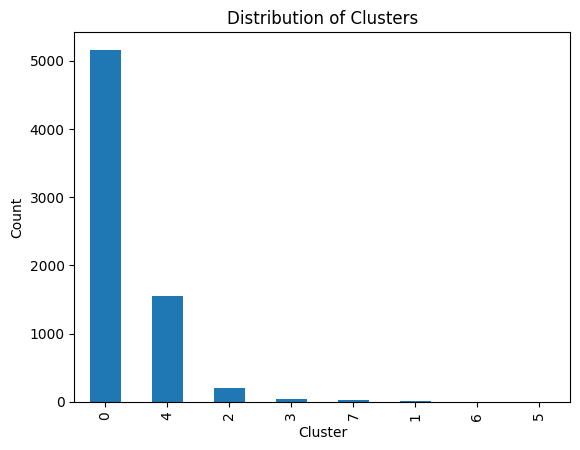

In [10]:
# Esegui il clustering K-means
kmeans = KMeans(n_clusters=8, random_state=0).fit(core_users_pca)

# Aggiungi le etichette dei cluster ai dati
core_users_clustering['kmeans_cluster'] = kmeans.labels_

# Visualizza la distribuzione dei cluster
core_users_clustering['kmeans_cluster'].value_counts().plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution of Clusters')
plt.show()


In [15]:
# # Creiamo uno scatter plot
# # plt.figure(figsize=(10, 7))
#
# # Coloriamo i punti in base al cluster a cui appartengono
# plt.scatter(core_users_pca[:, 0], core_users_pca[:, 1], c=core_users_clustering['kmeans_cluster'], cmap='viridis')
#
# plt.title('K-Means Clustering with PCA')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
#
# plt.show()



# Creazione del grafico 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Aggiungi i punti al grafico
scatter = ax.scatter(core_users_pca[:, 0], core_users_pca[:, 1], core_users_pca[:, 2], c=core_users_clustering['kmeans_cluster'], cmap='viridis')

# Aggiungi la legenda
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

# Etichette degli assi
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

# Visualizza il grafico
plt.show()


<IPython.core.display.Javascript object>

## DBSCAN

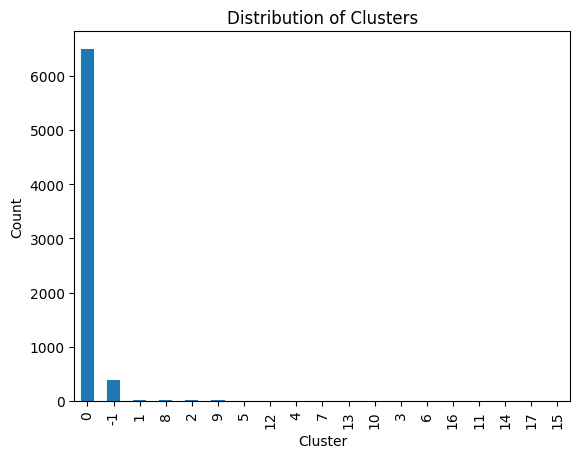

In [7]:
# Eseguiamo DBSCAN sui dati
db = DBSCAN(eps=0.1, min_samples=5).fit(core_users_pca)

# Aggiungi le etichette dei cluster ai dati
core_users_clustering['db_cluster'] = db.labels_

# Visualizza la distribuzione dei cluster
core_users_clustering['db_cluster'].value_counts().plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution of Clusters')
plt.show()


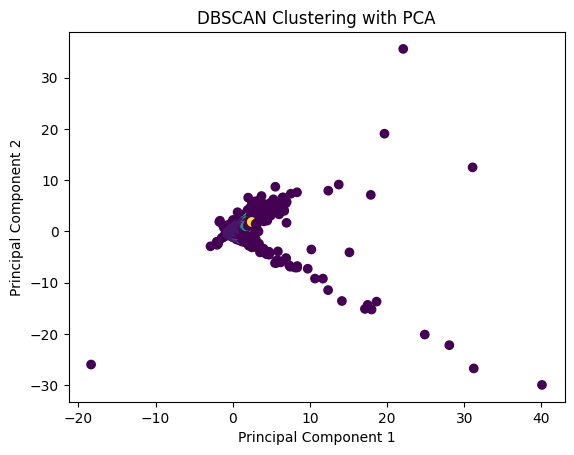

In [8]:
# Visualizziamo i risultati
# plt.figure(figsize=(10, 7))
plt.scatter(core_users_pca[:, 0], core_users_pca[:, 1], c=core_users_clustering['db_cluster'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('DBSCAN Clustering with PCA')
plt.show()

# # Creiamo uno scatter plot
# plt.figure(figsize=(10, 7))
# plt.scatter(core_users_pca[:, 0], core_users_pca[:, 1], c=core_users_clustering['db_cluster'], cmap='viridis')
# plt.title('DBSCAN Clustering with PCA')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.show()
